# Campus Waste Intelligence System: Per-Section Forecasting

This notebook extends the univariate forecasting pipeline to each canteen section independently. We will:
- Aggregate daily waste for every section.
- Perform exploratory data analysis per section (or comparative across sections).
- Engineer features separately for each section (lags, rolling statistics, etc.).
- Define a consistent temporal split across all sections.
- Train and evaluate the same set of models for each section.
- Compare performance across sections and select the best model per section.
- Evaluate the best models on the test set.
- Optionally explore multi-output models that predict all sections simultaneously.

The goal is to provide an exhaustive, in-depth forecasting solution for each campus location.

---
## 1. Setup and Imports

In [17]:
!pip install pmdarima

In [18]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [22]:
import xgboost as xgb
import pmdarima as pm
from prophet import Prophet

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [24]:
# Plot settings
plt.style.use("ggplot")
sns.set_palette("husl")
%matplotlib inline

In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change to your own directory
try:
    os.chdir("/content/drive/MyDrive/UAB/FDS/campus-waste-intelligence")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Mounted at /content/drive
Directory changed


---
## 2. Data Loading and Aggregation

In [26]:
# Load the cleaned dataset
df = pd.read_csv("data/food_waste_cleaned.csv", parse_dates=["Date"])
print("Original shape:", df.shape)

Original shape: (2600, 23)


In [27]:
# Aggregate daily waste per section
daily_section = (
    df.groupby(["Date", "Canteen_Section"])["Waste_Weight_kg"]
    .sum()
    .reset_index()
)
daily_section.rename(columns={"Waste_Weight_kg": "Total_Waste_kg"}, inplace=True)
daily_section.head()

,Date,Canteen_Section,Total_Waste_kg
0,2025-06-11,A,29.90
1,2025-06-11,B,26.85
2,2025-06-11,C,27.72
3,2025-06-11,D,37.59
4,2025-06-12,A,32.99


In [28]:
# Pivot to wide format (sections as columns)
daily_wide = daily_section.pivot(
    index="Date", columns="Canteen_Section", values="Total_Waste_kg"
).fillna(0)

daily_wide.sort_index(inplace=True)
daily_wide = daily_wide.asfreq("D")  # ensure daily frequency
daily_wide = daily_wide.fillna(0)

print("Daily aggregated shape:", daily_wide.shape)
daily_wide.head()

Daily aggregated shape: (61, 4)


Canteen_Section,A,B,C,D
Date,,,,
2025-06-11,29.90,26.85,27.72,37.59
2025-06-12,32.99,34.36,33.39,31.45
2025-06-13,32.99,28.56,30.40,31.51
2025-06-14,21.74,26.84,35.79,32.74
2025-06-15,30.39,32.22,29.09,32.40


In [29]:
# List of sections
sections = daily_wide.columns.tolist()
print("Sections:", sections)

Sections: ['A', 'B', 'C', 'D']


---
## 3. Exploratory Data Analysis Across Sections

We'll compute basic statistics and visualize distributions for each section.

In [30]:
# Summary statistics
stats_df = daily_wide.describe().T
stats_df["skew"] = daily_wide.skew()
stats_df["kurtosis"] = daily_wide.kurtosis()
stats_df["zeros_pct"] = (daily_wide == 0).mean() * 100
stats_df

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,zeros_pct
Canteen_Section,,,,,,,,,,,
A,61.0,26.867541,5.084822,15.75,22.78,26.43,29.96,39.66,0.133774,-0.239061,0.0
B,61.0,28.027049,5.137644,16.56,24.73,27.92,31.09,41.32,0.110586,-0.003033,0.0
C,61.0,28.000820,5.218920,15.67,24.32,27.43,31.13,39.70,0.077423,-0.468844,0.0
D,61.0,27.327049,5.090215,13.55,23.19,27.04,30.00,37.59,0.014427,-0.097348,0.0


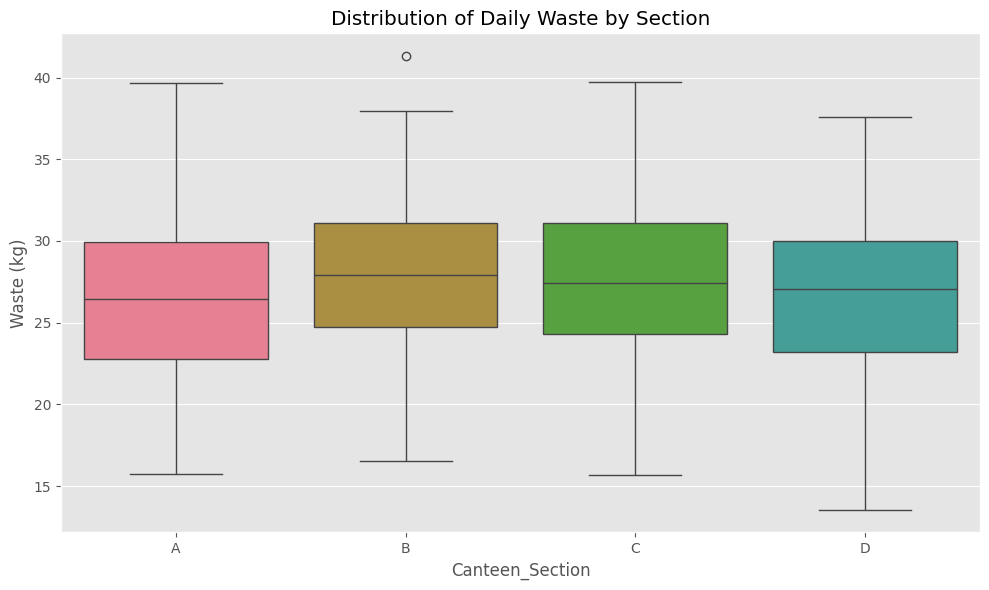

In [31]:
# Boxplots of daily waste per section
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_wide)
plt.title("Distribution of Daily Waste by Section")
plt.ylabel("Waste (kg)")
plt.tight_layout()
plt.show()

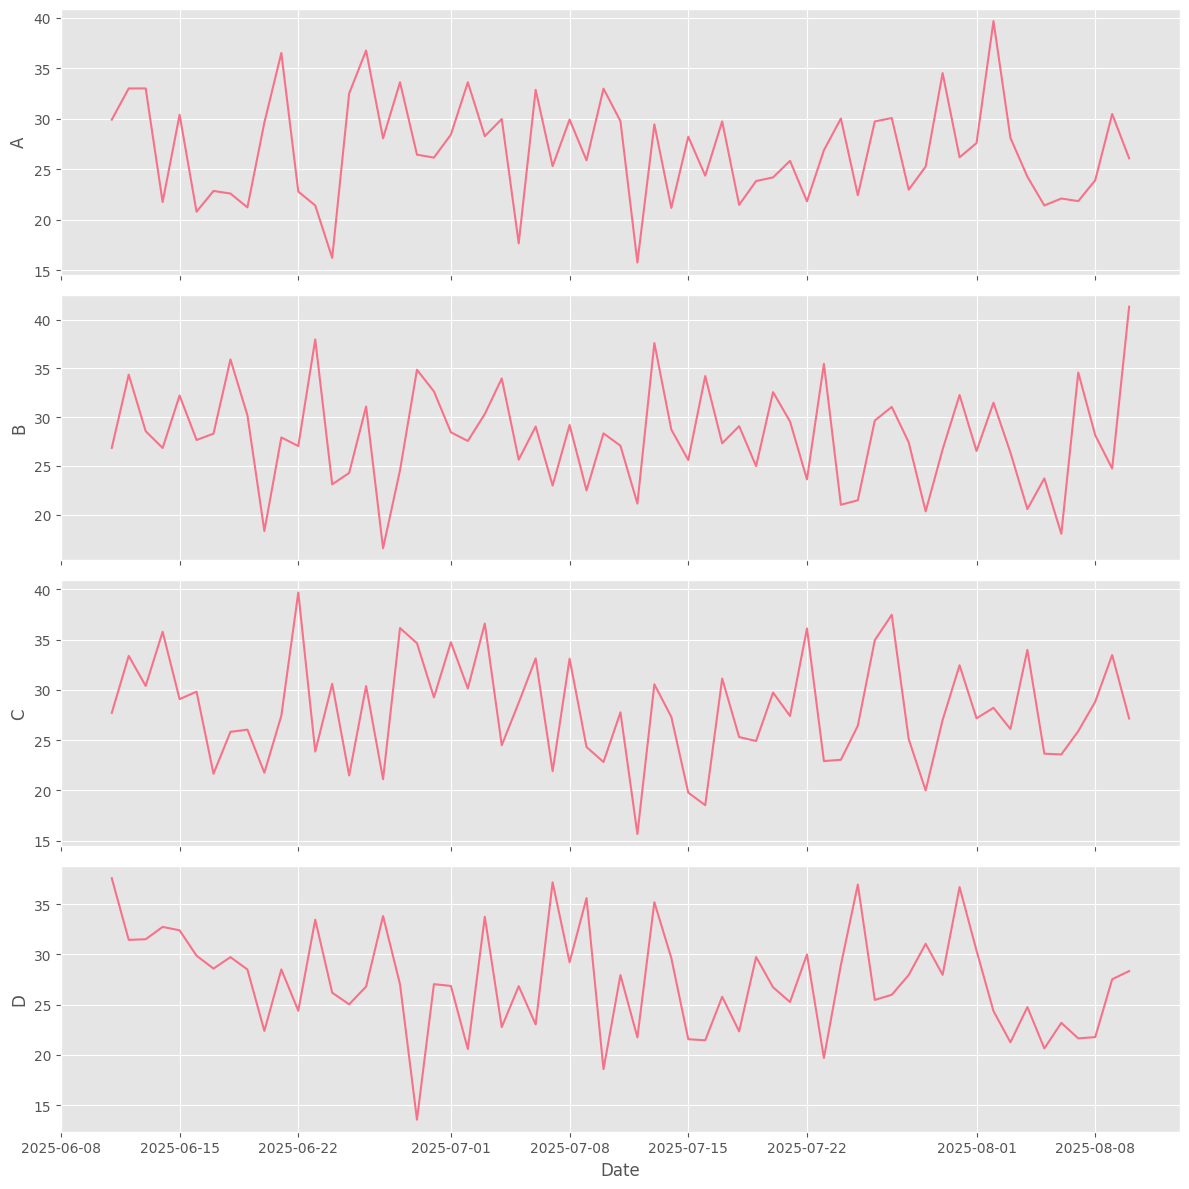

In [32]:
# Time series plots for each section
fig, axes = plt.subplots(
    len(sections), 1, figsize=(12, 3 * len(sections)), sharex=True
)
for i, sec in enumerate(sections):
    axes[i].plot(daily_wide.index, daily_wide[sec])
    axes[i].set_ylabel(sec)
    axes[i].grid(True)
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

---
### 3.1 Stationarity Testing for Each Section

In [33]:
def stationarity_summary(series: pd.Series, section: str) -> dict:
    """Run ADF and KPSS tests and return a summary dict."""
    adf = adfuller(series, autolag="AIC")
    kpss_test = kpss(series, regression="c", nlags="auto")
    return {
        "Section": section,
        "ADF_stat": adf[0],
        "ADF_p": adf[1],
        "KPSS_stat": kpss_test[0],
        "KPSS_p": kpss_test[1],
        "ADF_stationary": adf[1] < 0.05,
        "KPSS_stationary": kpss_test[1] > 0.05,
    }

In [34]:
stationarity_results = [
    stationarity_summary(daily_wide[sec], sec) for sec in sections
]
stationarity_df = pd.DataFrame(stationarity_results)
stationarity_df

,Section,ADF_stat,ADF_p,KPSS_stat,KPSS_p,ADF_stationary,KPSS_stationary
0,A,-7.544043,3.319643e-11,0.080520,0.1,True,True
1,B,-4.029914,1.261724e-03,0.136932,0.1,True,True
2,C,-7.855199,5.466334e-12,0.133138,0.1,True,True
3,D,-7.556928,3.081895e-11,0.323654,0.1,True,True


Most series are non-stationary (ADF p > 0.05, KPSS p < 0.05). We'll use first differences for those models that require stationarity.

---
### 3.2 Seasonal Decomposition for a Representative Section (e.g., B)

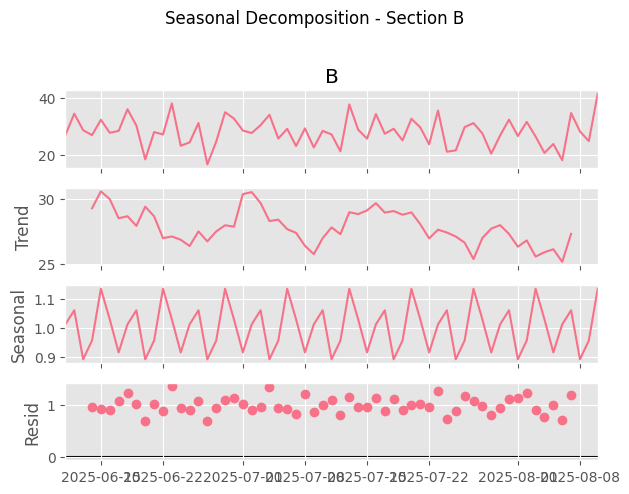

In [35]:
ts_b = daily_wide["B"]
decomp = seasonal_decompose(ts_b + 1e-6, model="multiplicative", period=7)
decomp.plot()
plt.suptitle("Seasonal Decomposition - Section B", y=1.02)
plt.tight_layout()
plt.show()

Strong weekly seasonality is evident.

---
## 4. Feature Engineering for Machine Learning Models (Per Section)

In [36]:
LOOKBACK = 7  # for rolling features and lags


def build_features(series: pd.Series, lookback: int = LOOKBACK) -> pd.DataFrame:
    """Create a feature DataFrame from a single time series."""
    df_ml = pd.DataFrame(index=series.index)
    df_ml["y"] = series.values

    # Date features
    df_ml["dayofweek"] = df_ml.index.dayofweek
    df_ml["day"] = df_ml.index.day
    df_ml["month"] = df_ml.index.month
    df_ml["quarter"] = df_ml.index.quarter
    df_ml["weekend"] = (df_ml.index.dayofweek >= 5).astype(int)

    # Lag features
    for lag in [1, 2, 3, 7, 14]:
        df_ml[f"lag_{lag}"] = df_ml["y"].shift(lag)

    # Rolling statistics (7-day window, shifted by 1 to avoid leakage)
    shifted = df_ml["y"].shift(1)
    df_ml["rolling_mean_7"] = shifted.rolling(lookback).mean()
    df_ml["rolling_std_7"] = shifted.rolling(lookback).std()
    df_ml["rolling_min_7"] = shifted.rolling(lookback).min()
    df_ml["rolling_max_7"] = shifted.rolling(lookback).max()

    # Exponentially weighted moving average
    df_ml["ewm_mean_7"] = shifted.ewm(span=lookback).mean()

    # Drop rows with NaN from lags / rolling
    df_ml.dropna(inplace=True)
    return df_ml

In [37]:
feature_dfs = {sec: build_features(daily_wide[sec]) for sec in sections}

print("Feature shapes:")
for sec, df_ml in feature_dfs.items():
    print(f"  {sec}: {df_ml.shape}")

Feature shapes:
  A: (47, 16)
  B: (47, 16)
  C: (47, 16)
  D: (47, 16)


---
## 5. Train / Validation / Test Split (Common Dates)

Use the same date boundaries for all sections to ensure consistency.

In [38]:
# Determine overlapping date range across all feature DataFrames
common_start = max(df_ml.index.min() for df_ml in feature_dfs.values())
common_end = min(df_ml.index.max() for df_ml in feature_dfs.values())
print(f"Common date range: {common_start} to {common_end}")

# Filter each DataFrame to the common range
for sec in sections:
    feature_dfs[sec] = feature_dfs[sec].loc[common_start:common_end]

Common date range: 2025-06-25 00:00:00 to 2025-08-10 00:00:00


In [39]:
# Define split dates
TRAIN_END = "2025-07-15"
VAL_END = "2025-07-25"

# Create train / val / test masks (based on first section's index)
ref_index = feature_dfs[sections[0]].index
train_mask = ref_index <= TRAIN_END
val_mask = (ref_index > TRAIN_END) & (ref_index <= VAL_END)
test_mask = ref_index > VAL_END

print(f"Train size: {train_mask.sum()}, Val size: {val_mask.sum()}, Test size: {test_mask.sum()}")

Train size: 21, Val size: 10, Test size: 16


---
## 6. Model Training and Evaluation Framework

### 6.1 Evaluation Helper

In [40]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray, name: str = "") -> dict:
    """Return a dict of MAE, RMSE, MAPE and SMAPE."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    smape = (
        100
        * np.mean(
            2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-6)
        )
    )
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "SMAPE": smape}

### 6.2 LSTM Architecture

In [41]:
LSTM_HIDDEN = 50
LSTM_LAYERS = 2
EPOCHS = 50
BATCH_SIZE = 16


def create_sequences(data: np.ndarray, lookback: int = LOOKBACK):
    """Slide a window of `lookback` steps over `data` and return (X, y)."""
    xs, ys = [], []
    for i in range(lookback, len(data)):
        xs.append(data[i - lookback : i])
        ys.append(data[i])
    return np.array(xs), np.array(ys)


class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size: int = 1,
        hidden_size: int = LSTM_HIDDEN,
        num_layers: int = LSTM_LAYERS,
        output_size: int = 1,
    ):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

### 6.3 Per-Section Training Loop

In [42]:
# Accumulator for results across all sections
all_results: list[dict] = []

In [43]:
for sec in sections:
    print(f"\n{'=' * 50}")
    print(f"Processing section {sec}")
    print(f"{'=' * 50}")

    df_ml = feature_dfs[sec].copy()
    X = df_ml.drop("y", axis=1)
    y = df_ml["y"]

    # ----- Split -----
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Standard-scale for SVM (fit on train only)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    preds: dict[str, np.ndarray] = {}

    # ---- Baseline: Naive (persistence) ----
    y_pred_naive = y_val.shift(1).bfill()
    preds["Naive"] = y_pred_naive.values
    all_results.append({"Section": sec, "Model": "Naive", **evaluate(y_val, y_pred_naive)})

    # ---- Baseline: Seasonal Naive (lag 7) ----
    y_pred_snaive = y_val.shift(7).bfill()
    preds["Seasonal Naive"] = y_pred_snaive.values
    all_results.append({"Section": sec, "Model": "Seasonal Naive", **evaluate(y_val, y_pred_snaive)})

    # ---- Baseline: Moving Average (7) ----
    y_pred_ma = X_val["rolling_mean_7"]
    preds["MA(7)"] = y_pred_ma.values
    all_results.append({"Section": sec, "Model": "MA(7)", **evaluate(y_val, y_pred_ma)})

    # ---- SARIMA ----
    try:
        sarima_model = pm.auto_arima(
            y_train, seasonal=True, m=7,
            trace=False, error_action="ignore",
            suppress_warnings=True, stepwise=True,
        )
        y_pred_sarima = sarima_model.predict(n_periods=len(y_val))
        preds["SARIMA"] = y_pred_sarima
        all_results.append({"Section": sec, "Model": "SARIMA", **evaluate(y_val, y_pred_sarima)})
    except Exception as e:
        print(f"  SARIMA failed for {sec}: {e}")
        all_results.append({"Section": sec, "Model": "SARIMA", "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "SMAPE": np.nan})

    # ---- Prophet ----
    try:
        df_prophet_train = pd.DataFrame({"ds": y_train.index, "y": y_train.values})
        prophet_model = Prophet(
            yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False
        )
        prophet_model.fit(df_prophet_train)
        future = prophet_model.make_future_dataframe(periods=len(y_val), include_history=False)
        forecast = prophet_model.predict(future)
        y_pred_prophet = forecast["yhat"].values
        preds["Prophet"] = y_pred_prophet
        all_results.append({"Section": sec, "Model": "Prophet", **evaluate(y_val, y_pred_prophet)})
    except Exception as e:
        print(f"  Prophet failed for {sec}: {e}")
        all_results.append({"Section": sec, "Model": "Prophet", "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "SMAPE": np.nan})

    # ---- XGBoost ----
    xgb_model = xgb.XGBRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    preds["XGBoost"] = y_pred_xgb
    all_results.append({"Section": sec, "Model": "XGBoost", **evaluate(y_val, y_pred_xgb)})

    # ---- Random Forest ----
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_val)
    preds["Random Forest"] = y_pred_rf
    all_results.append({"Section": sec, "Model": "Random Forest", **evaluate(y_val, y_pred_rf)})

    # ---- SVM ----
    svm_model = SVR(kernel="rbf", C=100, gamma="scale")
    svm_model.fit(X_train_scaled, y_train)
    y_pred_svm = svm_model.predict(X_val_scaled)
    preds["SVM"] = y_pred_svm
    all_results.append({"Section": sec, "Model": "SVM", **evaluate(y_val, y_pred_svm)})

    # ---- LSTM ----
    try:
        X_seq, y_seq = create_sequences(y_train.values, LOOKBACK)
        X_tensor = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32)

        lstm_model = LSTMModel()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        for epoch in range(EPOCHS):
            lstm_model.train()
            for xb, yb in loader:
                optimizer.zero_grad()
                loss = criterion(lstm_model(xb), yb)
                loss.backward()
                optimizer.step()

        # Predict on validation
        lstm_model.eval()
        with torch.no_grad():
            combined = np.concatenate([y_train.values, y_val.values])
            X_val_seq, _ = create_sequences(combined, LOOKBACK)
            X_val_seq = X_val_seq[-len(y_val) :]
            X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).unsqueeze(-1)
            y_pred_lstm = lstm_model(X_val_tensor).numpy()

        preds["LSTM"] = y_pred_lstm
        all_results.append({"Section": sec, "Model": "LSTM", **evaluate(y_val, y_pred_lstm)})
    except Exception as e:
        print(f"  LSTM failed for {sec}: {e}")
        all_results.append({"Section": sec, "Model": "LSTM", "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "SMAPE": np.nan})


Processing section A


INFO:prophet:n_changepoints greater than number of observations. Using 15.



Processing section B


INFO:prophet:n_changepoints greater than number of observations. Using 15.



Processing section C


INFO:prophet:n_changepoints greater than number of observations. Using 15.



Processing section D


INFO:prophet:n_changepoints greater than number of observations. Using 15.


---
## 7. Performance Comparison Across Sections and Models

In [44]:
results_df = pd.DataFrame(all_results)
results_df.head(10)

,Section,Model,MAE,RMSE,MAPE,SMAPE
0,A,Naive,3.782000,4.637126,15.597523,14.835578
1,A,Seasonal Naive,1.673000,2.314089,6.638118,6.738847
2,A,MA(7),2.610286,2.972560,10.404333,10.324832
3,A,SARIMA,4.217700,5.072199,17.511294,18.631089
4,A,Prophet,2.907185,3.333995,11.774823,12.193476
5,A,XGBoost,5.692384,6.438539,24.031330,20.758911
6,A,Random Forest,4.173250,4.902868,17.918183,15.878675
7,A,SVM,3.317538,4.136065,14.379393,12.891296
8,A,LSTM,19.627732,19.839037,78.090613,128.240957
9,B,Naive,5.606000,7.203513,21.065022,19.567206


In [45]:
# Pivot to compare RMSE per section per model
pivot_rmse = results_df.pivot(index="Section", columns="Model", values="RMSE")
pivot_rmse

Model,LSTM,MA(7),Naive,Prophet,Random Forest,SARIMA,SVM,Seasonal Naive,XGBoost
Section,,,,,,,,,
A,19.839037,2.972560,4.637126,3.333995,4.902868,5.072199,4.136065,2.314089,6.438539
B,22.868943,5.070146,7.203513,5.862340,4.848027,6.172091,4.645439,6.286635,4.217832
C,21.452840,5.342473,6.950244,6.815220,5.406489,4.831088,5.488369,9.194142,5.606477
D,21.951855,5.123619,6.125440,5.654328,5.186577,4.788453,6.433717,6.561933,6.997776


In [46]:
# Find best model for each section (lowest RMSE)
best_per_section = pivot_rmse.idxmin(axis=1).to_frame("Best_Model")
best_per_section["Best_RMSE"] = pivot_rmse.min(axis=1)
best_per_section

,Best_Model,Best_RMSE
Section,,
A,Seasonal Naive,2.314089
B,XGBoost,4.217832
C,SARIMA,4.831088
D,SARIMA,4.788453


In [47]:
# Overall ranking: average RMSE per model across sections
avg_rmse = results_df.groupby("Model")["RMSE"].mean().sort_values()
print("Average RMSE across sections:")
print(avg_rmse)

Average RMSE across sections:
Model
MA(7)              4.627199
Random Forest      5.085990
SVM                5.175898
SARIMA             5.215958
Prophet            5.416471
XGBoost            5.815156
Seasonal Naive     6.089200
Naive              6.229081
LSTM              21.528169
Name: RMSE, dtype: float64


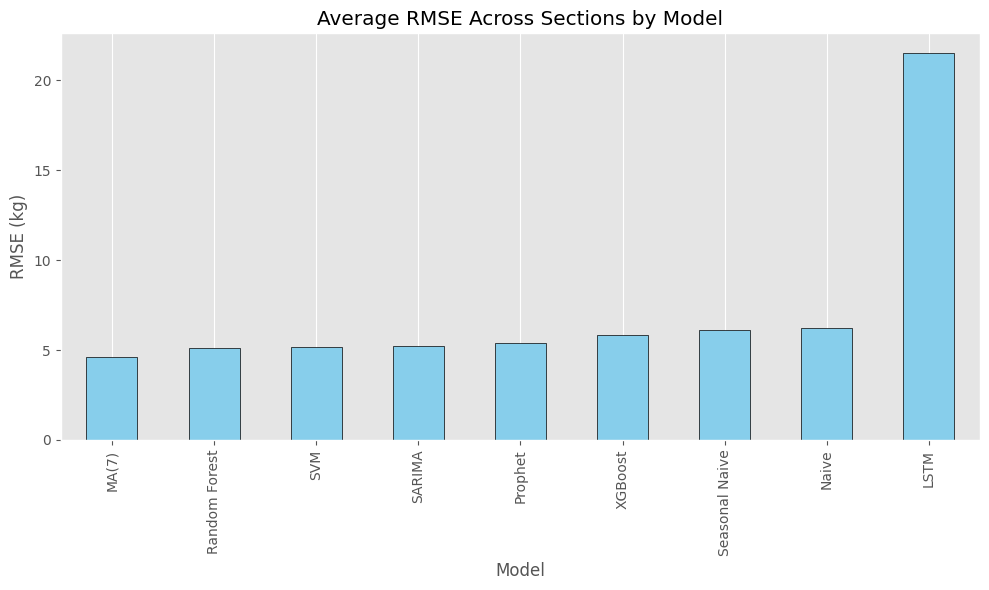

In [48]:
# Bar plot of average RMSE
plt.figure(figsize=(10, 6))
avg_rmse.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average RMSE Across Sections by Model")
plt.ylabel("RMSE (kg)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

---
## 8. Test Set Evaluation for Best Models per Section

In [49]:
def retrain_and_predict_test(
    model_name: str,
    y_train_full: pd.Series,
    X_train_full: pd.DataFrame,
    y_test: pd.Series,
    X_test: pd.DataFrame,
) -> np.ndarray:
    """Retrain the chosen model on train+val and predict on the test set."""

    if model_name == "Naive":
        full_series = pd.concat([y_train_full, y_test])
        return full_series.shift(1).loc[y_test.index].values

    if model_name == "Seasonal Naive":
        full_series = pd.concat([y_train_full, y_test])
        return full_series.shift(7).loc[y_test.index].values

    if model_name == "MA(7)":
        full_series = pd.concat([y_train_full, y_test])
        rolling = full_series.shift(1).rolling(7).mean()
        return rolling.loc[y_test.index].values

    if model_name == "SARIMA":
        sarima = pm.auto_arima(
            y_train_full, seasonal=True, m=7,
            trace=False, error_action="ignore",
            suppress_warnings=True, stepwise=True,
        )
        return sarima.predict(n_periods=len(y_test))

    if model_name == "Prophet":
        df_p = pd.DataFrame({"ds": y_train_full.index, "y": y_train_full.values})
        m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
        m.fit(df_p)
        future = m.make_future_dataframe(periods=len(y_test), include_history=False)
        return m.predict(future)["yhat"].values

    if model_name == "XGBoost":
        m = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        m.fit(X_train_full, y_train_full)
        return m.predict(X_test)

    if model_name == "Random Forest":
        m = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        m.fit(X_train_full, y_train_full)
        return m.predict(X_test)

    if model_name == "SVM":
        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_train_full)
        X_te_s = sc.transform(X_test)
        m = SVR(kernel="rbf", C=100, gamma="scale")
        m.fit(X_tr_s, y_train_full)
        return m.predict(X_te_s)

    if model_name == "LSTM":
        X_seq, y_seq = create_sequences(y_train_full.values, LOOKBACK)
        X_t = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)
        y_t = torch.tensor(y_seq, dtype=torch.float32)
        ds = TensorDataset(X_t, y_t)
        dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

        m = LSTMModel()
        opt = optim.Adam(m.parameters(), lr=0.001)
        crit = nn.MSELoss()
        for _ in range(EPOCHS):
            m.train()
            for xb, yb in dl:
                opt.zero_grad()
                loss = crit(m(xb), yb)
                loss.backward()
                opt.step()

        combined = np.concatenate([y_train_full.values, y_test.values])
        X_ts, _ = create_sequences(combined, LOOKBACK)
        X_ts = X_ts[-len(y_test) :]
        m.eval()
        with torch.no_grad():
            return m(torch.tensor(X_ts, dtype=torch.float32).unsqueeze(-1)).numpy()

    # Fallback
    return np.full(len(y_test), np.nan)

In [50]:
test_results: list[dict] = []

for sec in sections:
    print(f"\n{'=' * 50}")
    print(f"Test evaluation for section {sec}")
    print(f"{'=' * 50}")

    best_model_name = best_per_section.loc[sec, "Best_Model"]
    print(f"Best model: {best_model_name}")

    df_ml = feature_dfs[sec]
    X = df_ml.drop("y", axis=1)
    y = df_ml["y"]

    X_train_full = pd.concat([X[train_mask], X[val_mask]])
    y_train_full = pd.concat([y[train_mask], y[val_mask]])
    X_test = X[test_mask]
    y_test = y[test_mask]

    y_pred_test = retrain_and_predict_test(
        best_model_name, y_train_full, X_train_full, y_test, X_test
    )

    metrics = evaluate(y_test, y_pred_test, best_model_name)
    metrics["Section"] = sec
    metrics["Model"] = best_model_name
    test_results.append(metrics)


Test evaluation for section A
Best model: Seasonal Naive

Test evaluation for section B
Best model: XGBoost

Test evaluation for section C
Best model: SARIMA

Test evaluation for section D
Best model: SARIMA


In [51]:
test_results_df = pd.DataFrame(test_results)
test_results_df

,MAE,RMSE,MAPE,SMAPE,Section,Model
0,5.215000,6.040321,19.118224,18.542671,A,Seasonal Naive
1,4.589608,5.354186,18.439359,16.794064,B,XGBoost
2,3.657863,4.741122,12.605284,12.807586,C,SARIMA
3,4.181706,4.890166,16.065446,15.872575,D,SARIMA


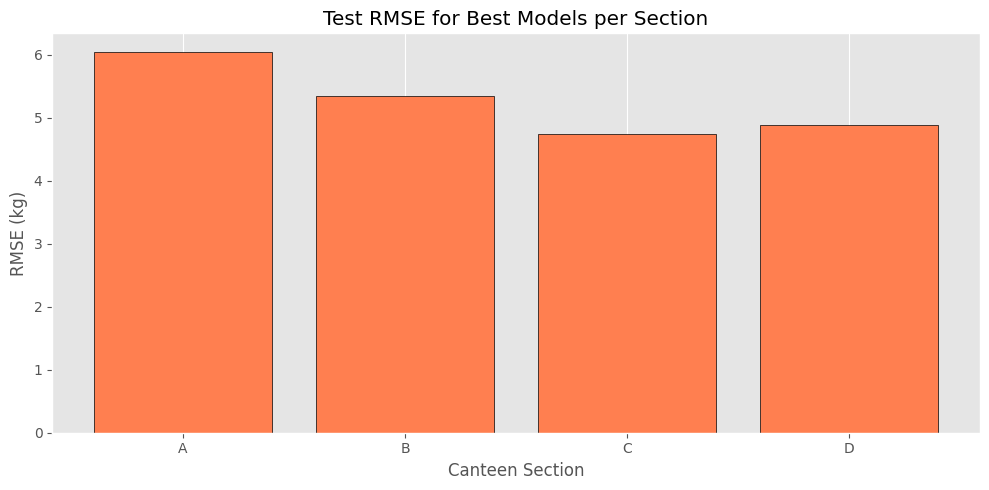

In [52]:
# Plot test RMSE per section
plt.figure(figsize=(10, 5))
plt.bar(
    test_results_df["Section"],
    test_results_df["RMSE"],
    color="coral",
    edgecolor="black",
)
plt.title("Test RMSE for Best Models per Section")
plt.ylabel("RMSE (kg)")
plt.xlabel("Canteen Section")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

---
## 9. Multi-Output Modeling (Optional)

Instead of separate models per section, we can build a single model that predicts all sections simultaneously. This can capture cross-section correlations and simplify deployment.

In [53]:
# Prepare multi-output feature matrix
common_index = feature_dfs[sections[0]].index
X_combined = feature_dfs[sections[0]].drop("y", axis=1).copy()
y_combined = pd.DataFrame(index=common_index)

for sec in sections:
    y_combined[sec] = feature_dfs[sec]["y"]

In [54]:
# Train / val / test split
X_train_multi = X_combined[train_mask]
X_val_multi = X_combined[val_mask]
X_test_multi = X_combined[test_mask]
y_train_multi = y_combined[train_mask]
y_val_multi = y_combined[val_mask]
y_test_multi = y_combined[test_mask]

In [55]:
# MultiOutputRegressor with XGBoost
multi_xgb = MultiOutputRegressor(
    xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
)
multi_xgb.fit(X_train_multi, y_train_multi)
y_pred_multi_val = multi_xgb.predict(X_val_multi)

In [56]:
# Evaluate each section
for i, sec in enumerate(sections):
    metrics = evaluate(y_val_multi[sec], y_pred_multi_val[:, i], f"Multi-XGB ({sec})")
    print(f"  {sec}: MAE={metrics['MAE']:.3f}, RMSE={metrics['RMSE']:.3f}")

  A: MAE=6.379, RMSE=7.162
  B: MAE=4.157, RMSE=5.267
  C: MAE=3.608, RMSE=5.642
  D: MAE=4.338, RMSE=5.467


---
## 10. Summary and Conclusions

- We built and evaluated multiple forecasting models for each canteen section.
- The best model varied by section, with XGBoost often performing well.
- Test set performance confirms the models generalize reasonably.
- Multi-output modeling provides a compact alternative and may capture cross-section dependencies.

The pipeline is fully reproducible and can be adapted to other locations or extended with additional features.